 # Feature Engineering, Baseline Model and Feature Selection

 ## Import necessary dependencies

In [3]:
import pandas
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy
from sklearn.feature_selection import chi2
from PIL import Image
from collections import Counter
import re
import sqlite3
from sklearn import decomposition, ensemble
import nltk
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence
import pydot
import seaborn as sns


Using TensorFlow backend.


 ## Load in the data from the database

In [9]:
dbconn = sqlite3.connect('./data/cleanedtraintest_v2.db')
train_data_df = pandas.read_sql_query('SELECT * FROM train_data', dbconn)
test_data_df = pandas.read_sql_query('SELECT * FROM test_data', dbconn)
dbconn.commit()
dbconn.close()


 ### Check the if the data was loaded correctly

In [12]:
train_data_df.head()


,index,category,headline,content,headline_cleaned,content_cleaned,content_nosources
0,0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall bears claw back black,wall street seeing green,"Short-sellers, Wall Street's dwindling\band ..."
1,1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace,private investment firm carlyle group reputati...,"Private investment firm Carlyle Group,\which..."
2,2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil economy cloud stocks outlook,soaring crude prices plus economy outlook earn...,Soaring crude prices plus worries\about the ...
3,3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports main southern pipeline,authorities halted oil main pipeline southern ...,Authorities have halted oil export\flows fro...
4,4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",oil prices soar record posing new menace us ec...,tearaway world oil prices toppling records str...,"Tearaway world oil prices, toppling records ..."


In [14]:
train_data_df.drop('index', axis=1, inplace=True)
train_data_df.head()


,category,headline,content,headline_cleaned,content_cleaned,content_nosources
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall bears claw back black,wall street seeing green,"Short-sellers, Wall Street's dwindling\band ..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace,private investment firm carlyle group reputati...,"Private investment firm Carlyle Group,\which..."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil economy cloud stocks outlook,soaring crude prices plus economy outlook earn...,Soaring crude prices plus worries\about the ...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports main southern pipeline,authorities halted oil main pipeline southern ...,Authorities have halted oil export\flows fro...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",oil prices soar record posing new menace us ec...,tearaway world oil prices toppling records str...,"Tearaway world oil prices, toppling records ..."


In [16]:
test_data_df.head()


,index,category,headline,content,headline_cleaned,content_cleaned,content_nosources
0,0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,fears n pension talks,unions representing workers turner newall say ...,Unions representing workers at Turner Newall...
1,1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...",race second private team sets launch date huma...,toronto canada rocketeers competing million an...,"TORONTO, Canada -- A second\team of rocketee..."
2,2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,company wins grant study peptides,company founded chemistry researcher universit...,A company founded by a chemistry researcher ...
3,3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,prediction unit helps forecast wildfires,barely dawn mike fitzpatrick starts shift blur...,It's barely dawn when Mike Fitzpatrick start...
4,4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...,calif aims limit smog,southern california agency went emissions bovi...,Southern California's smog-fighting agency w...


In [18]:
test_data_df.drop('index', axis=1, inplace=True)
test_data_df.head()


,category,headline,content,headline_cleaned,content_cleaned,content_nosources
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,fears n pension talks,unions representing workers turner newall say ...,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...",race second private team sets launch date huma...,toronto canada rocketeers competing million an...,"TORONTO, Canada -- A second\team of rocketee..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,company wins grant study peptides,company founded chemistry researcher universit...,A company founded by a chemistry researcher ...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,prediction unit helps forecast wildfires,barely dawn mike fitzpatrick starts shift blur...,It's barely dawn when Mike Fitzpatrick start...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...,calif aims limit smog,southern california agency went emissions bovi...,Southern California's smog-fighting agency w...


 ### Sample 4000 rows

In [21]:
train_data_sample = train_data_df.sample(n = 4000, replace = False, random_state = 123)
train_data_sample.head()


,category,headline,content,headline_cleaned,content_cleaned,content_nosources
30870,2,"NHL on Ice, Maybe for Whole 2004-05 Season (AP)","AP - No shots, no saves, no goals. The Nationa...",nhl ice maybe whole season,shots saves goals national hockey league locke...,"No shots, no saves, no goals. The National H..."
7738,2,Rowers to be punished for criticism of teammate,ROWER Sally Robbins #39;s teammates are expect...,rowers punished criticism teammate,rower sally robbins teammates expected face di...,ROWER Sally Robbins #39;s teammates are expect...
25351,2,Changing Directions,"Over at USA Today -- Slogan: ""All the News Tha...",changing directions,slogan news fit print four paragraphs less got...,"Over at - Slogan: ""All the News That's Fit to..."
74309,4,Cassini snapshots murky moon Titan,The Cassini probe got the first close-up photo...,cassini snapshots murky moon titan,cassini probe got first photos saturn murky mo...,The Cassini probe got the first close-up photo...
88347,1,Farewell Yasser Arafat,"GAZA CITY, 12 November 2004 - The world will b...",farewell yasser arafat,gaza city world bid farewell abu ammar yasser ...,"GAZA CITY, - The world will bid farewell to Ab..."


In [23]:
test_data_sample = test_data_df.sample(n = 4000, replace = False, random_state = 123)
test_data_sample.head()


,category,headline,content,headline_cleaned,content_cleaned,content_nosources
646,1,Panama pardons Castro 'plotters',Four men accused of planning to kill Cuba's Fi...,panama pardons castro,four men accused planning kill cuba fidel cast...,Four men accused of planning to kill Cuba's Fi...
2616,4,Elephant DNA Could Help Stem Ivory Trade (AP),AP - Analyzing the DNA of elephants may help t...,elephant dna could help stem ivory trade,analyzing dna elephants may help trace origins...,Analyzing the DNA of elephants may help trac...
2300,1,Job-Loss Panic Rises in Western Europe (AP),AP - Stephane Zervos first suspected his job w...,panic rises western europe,stephane zervos first suspected job threatened...,Stephane Zervos first suspected his job was ...
4764,1,Remark on Homosexuality Delays Seating of Euro...,The European Union #39;s normally yawn-inducin...,remark homosexuality delays seating european p...,european union normally institutions raised ey...,The European Union #39;s normally yawn-inducin...
3617,3,Linux: Paris weighs a shift to open-source camp,PARIS The open-source computer system known as...,linux paris weighs shift camp,paris computer system known linux tough battle...,PARIS The open-source computer system known as...


 ### Let's make a Bag of Words

In [26]:
# Use countvectorizer to get a vector of words
cv = CountVectorizer(min_df = 2, lowercase = True,
                     token_pattern=r'\b[A-Za-z]{2,}\b', ngram_range = (1, 1))
cv_matrix = cv.fit_transform(train_data_sample.content_cleaned).toarray()

# below is if wanted to define a specific category for the data.
# cv_matrix = cv.fit_transform(train_data_df[train_data_df.category == 1].headline_cleaned).toarray()

# get all unique words in the corpus
vocab = cv.get_feature_names()

# produce a dataframe including the feature names
headline_bagofwords_df = pandas.DataFrame(cv_matrix, columns=vocab)
headline_bagofwords_df.head()


,aaron,ab,abandon,abandoned,abandons,abbas,abc,abducted,abduction,abductions,...,zaragoza,zdnet,zealand,zee,zero,zimbabwe,zone,zook,zurich,zvonareva
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 ### We have bag of words already, let's make a Bag of N-Grams

In [29]:
# Use countvectorizer to get a vector of ngrams
cv = CountVectorizer(min_df = 2, lowercase = True,
                     token_pattern=r'\b[A-Za-z]{2,}\b', ngram_range = (2, 3))
cv_matrix = cv.fit_transform(train_data_sample.content_cleaned).toarray()

# below is if wanted to define a specific category for the data.
# cv_matrix = cv.fit_transform(train_data_df[train_data_df.category == 1].headline_cleaned).toarray()

# get all unique words in the corpus
vocab = cv.get_feature_names()

# produce a dataframe including the feature names
headline_bagofngrams_df = pandas.DataFrame(cv_matrix, columns=vocab)
headline_bagofngrams_df.head()


,ab billion,abducted militants,abductions foreigners,abductions foreigners iraq,aboard international,aboard international space,abu ghraib,abu ghraib prison,abu musab,ac milan,...,yukos said,yukos said would,zdnet survey,zdnet survey professionals,zealand biggest,zee tv,zimbabwe ruling,zimbabwe ruling party,zone central,zone central baghdad
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 ### Let's explore the data we got through plots and tables

[Text(0, 0, 'new york'),
 Text(0, 0, 'prime minister'),
 Text(0, 0, 'oil prices'),
 Text(0, 0, 'united states'),
 Text(0, 0, 'said wednesday'),
 Text(0, 0, 'said monday'),
 Text(0, 0, 'said tuesday'),
 Text(0, 0, 'red sox'),
 Text(0, 0, 'said thursday'),
 Text(0, 0, 'last night'),
 Text(0, 0, 'last week'),
 Text(0, 0, 'chief executive'),
 Text(0, 0, 'president bush'),
 Text(0, 0, 'said friday'),
 Text(0, 0, 'first time'),
 Text(0, 0, 'officials said'),
 Text(0, 0, 'company said'),
 Text(0, 0, 'world largest'),
 Text(0, 0, 'third quarter'),
 Text(0, 0, 'wall street'),
 Text(0, 0, 'said yesterday'),
 Text(0, 0, 'federal reserve'),
 Text(0, 0, 'next year'),
 Text(0, 0, 'los angeles'),
 Text(0, 0, 'last year'),
 Text(0, 0, 'least people'),
 Text(0, 0, 'mobile phone'),
 Text(0, 0, 'world cup'),
 Text(0, 0, 'hurricane ivan'),
 Text(0, 0, 'manchester united'),
 Text(0, 0, 'years ago'),
 Text(0, 0, 'european union'),
 Text(0, 0, 'san francisco'),
 Text(0, 0, 'yasser arafat'),
 Text(0, 0, 'unit

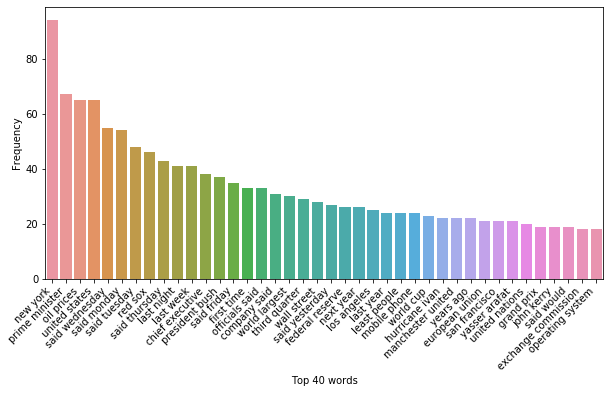

In [32]:
word_count_dict = {}
for word in vocab:
    word_count_dict[word] = int(sum(headline_bagofngrams_df.loc[:, word]))

counter = Counter(word_count_dict)

freq_df = pandas.DataFrame.from_records(counter.most_common(40),
                                        columns=['Top 40 words', 'Frequency'])

plt.figure(figsize=(10,5))
chart = sns.barplot(
    data=freq_df,
    x='Top 40 words',
    y='Frequency'
)

chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'
)


 ## TF/IDF

 ### Unigram TF/IDF

In [36]:
tfidf_vect = TfidfVectorizer(sublinear_tf = True, min_df = 2, ngram_range = (1, 1), 
                             use_idf = True, token_pattern=r'\b[A-Za-z]{2,}\b')
tfidf_unigram = tfidf_vect.fit_transform(train_data_sample.content_cleaned).toarray()
# get all unique words in the corpus
vocab = tfidf_vect.get_feature_names()

tfidf_unigram = pandas.DataFrame(numpy.round(tfidf_unigram, 2), columns = vocab)
tfidf_unigram.head()


,aaron,ab,abandon,abandoned,abandons,abbas,abc,abducted,abduction,abductions,...,zaragoza,zdnet,zealand,zee,zero,zimbabwe,zone,zook,zurich,zvonareva
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 ### N-Gram TF/IDF

In [39]:
tfidf_vect = TfidfVectorizer(sublinear_tf = True, min_df = 2, ngram_range = (2, 3), 
                             use_idf = True, token_pattern=r'\b[A-Za-z]{2,}\b')
tfidf_ngram = tfidf_vect.fit_transform(train_data_sample.content_cleaned).toarray()

# get all unique words in the corpus
vocab = tfidf_vect.get_feature_names()

tfidf_ngram = pandas.DataFrame(numpy.round(tfidf_ngram, 2), columns = vocab)
tfidf_ngram.head()


,ab billion,abducted militants,abductions foreigners,abductions foreigners iraq,aboard international,aboard international space,abu ghraib,abu ghraib prison,abu musab,ac milan,...,yukos said,yukos said would,zdnet survey,zdnet survey professionals,zealand biggest,zee tv,zimbabwe ruling,zimbabwe ruling party,zone central,zone central baghdad
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 ### Character TF/IDF

In [42]:
tfidf_vect = TfidfVectorizer(analyzer = 'char', sublinear_tf = True, min_df = 2, 
                             ngram_range = (2, 3), use_idf = True, 
                             token_pattern=r'\b[A-Za-z]{2,}\b')
tfidf_char = tfidf_vect.fit_transform(train_data_sample.content_cleaned).toarray()
tfidf_fit = tfidf_vect.fit_transform(train_data_sample.content_cleaned)

# get all unique words in the corpus
vocab = tfidf_vect.get_feature_names()

tfidf_char = pandas.DataFrame(numpy.round(tfidf_char, 2), columns = vocab)
tfidf_char.head()


,a,aa,ab,ac,ad,ae,af,ag,ah,ai,...,zur,zv,zvo,zy,zy,zz,zz,zza,zzi,zzl
0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
1,0.03,0.0,0.00,0.07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
2,0.03,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
3,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.13,0.14,0.0,0.0,0.0,0.0,0.0
4,0.06,0.0,0.07,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0


[Text(0, 0, 's '),
 Text(0, 0, 'in'),
 Text(0, 0, 'e '),
 Text(0, 0, ' s'),
 Text(0, 0, 'd '),
 Text(0, 0, 'er'),
 Text(0, 0, 't '),
 Text(0, 0, 'es'),
 Text(0, 0, 'on'),
 Text(0, 0, 're'),
 Text(0, 0, ' c'),
 Text(0, 0, 'st'),
 Text(0, 0, 'ed'),
 Text(0, 0, 'n '),
 Text(0, 0, 'te'),
 Text(0, 0, 'y '),
 Text(0, 0, 'an'),
 Text(0, 0, ' p'),
 Text(0, 0, 'ng'),
 Text(0, 0, 'ar'),
 Text(0, 0, 'en'),
 Text(0, 0, 'ti'),
 Text(0, 0, 'ed '),
 Text(0, 0, 'al'),
 Text(0, 0, 'or'),
 Text(0, 0, ' a'),
 Text(0, 0, 'le'),
 Text(0, 0, 'ne'),
 Text(0, 0, 'nt'),
 Text(0, 0, ' t'),
 Text(0, 0, 'ing'),
 Text(0, 0, 'r '),
 Text(0, 0, ' m'),
 Text(0, 0, 'g '),
 Text(0, 0, 'at'),
 Text(0, 0, 'ng '),
 Text(0, 0, ' r'),
 Text(0, 0, 'co'),
 Text(0, 0, 'ea'),
 Text(0, 0, 'se'),
 Text(0, 0, 'ri'),
 Text(0, 0, ' b'),
 Text(0, 0, 'l '),
 Text(0, 0, ' f'),
 Text(0, 0, 'de'),
 Text(0, 0, 'ra'),
 Text(0, 0, 'ro'),
 Text(0, 0, 'li'),
 Text(0, 0, 'ic'),
 Text(0, 0, 'io')]

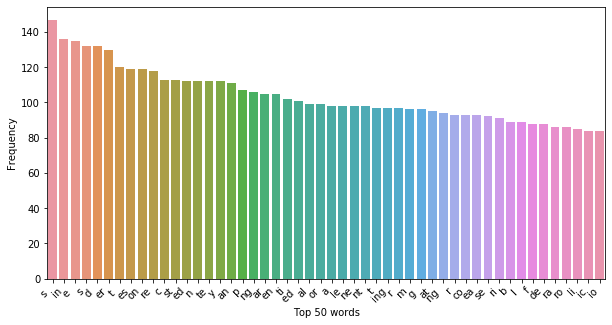

In [44]:
word_count_dict = {}
for word in vocab:
    word_count_dict[word] = int(sum(tfidf_char.loc[:, word]))

counter = Counter(word_count_dict)

freq_df = pandas.DataFrame.from_records(counter.most_common(50),
                                        columns=['Top 50 words', 'Frequency'])

plt.figure(figsize=(10,5))
chart = sns.barplot(
    data=freq_df,
    x='Top 50 words',
    y='Frequency'
)

chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'
)


 ## Document Similarity

In [47]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tfidf_fit)
similarity_df = pandas.DataFrame(similarity_matrix)
similarity_df


,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,1.000000,0.095259,0.164343,0.136964,0.085002,0.106770,0.161383,0.151646,0.166582,0.101963,...,0.130839,0.118731,0.125330,0.112532,0.146402,0.128665,0.100010,0.108122,0.136546,0.077240
1,0.095259,1.000000,0.074602,0.092086,0.190149,0.159834,0.158358,0.099680,0.119509,0.168387,...,0.057014,0.141423,0.138974,0.113837,0.088554,0.141727,0.126414,0.085801,0.147084,0.092092
2,0.164343,0.074602,1.000000,0.135493,0.129496,0.132866,0.150840,0.143989,0.150554,0.077022,...,0.117931,0.114257,0.109056,0.110385,0.148440,0.074880,0.140385,0.095980,0.129208,0.089120
3,0.136964,0.092086,0.135493,1.000000,0.100380,0.099874,0.113398,0.112133,0.111077,0.090205,...,0.147588,0.090534,0.162916,0.106458,0.138141,0.128705,0.071895,0.121315,0.150548,0.133394
4,0.085002,0.190149,0.129496,0.100380,1.000000,0.150315,0.140680,0.115041,0.114895,0.120666,...,0.102981,0.119532,0.156242,0.107706,0.155334,0.141434,0.118277,0.105968,0.122254,0.081994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.128665,0.141727,0.074880,0.128705,0.141434,0.096627,0.158732,0.186491,0.193820,0.095237,...,0.157934,0.143463,0.162309,0.099097,0.134725,1.000000,0.220851,0.117801,0.196105,0.146069
3996,0.100010,0.126414,0.140385,0.071895,0.118277,0.114325,0.134758,0.081212,0.083704,0.101485,...,0.117732,0.144555,0.072108,0.073279,0.096205,0.220851,1.000000,0.150132,0.104567,0.070278
3997,0.108122,0.085801,0.095980,0.121315,0.105968,0.054475,0.139955,0.119577,0.122685,0.109679,...,0.082717,0.072371,0.137245,0.097474,0.071417,0.117801,0.150132,1.000000,0.129988,0.060656
3998,0.136546,0.147084,0.129208,0.150548,0.122254,0.103778,0.181423,0.119995,0.147895,0.110204,...,0.122925,0.085255,0.169854,0.075314,0.129028,0.196105,0.104567,0.129988,1.000000,0.088644


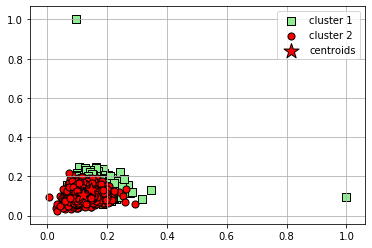

In [49]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(similarity_df)

#Convert to array for clustering to work
similarity_df_array = numpy.array(similarity_df)

# plot the 3 clusters
plt.scatter(
    similarity_df_array[y_km == 0, 0], similarity_df_array[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    similarity_df_array[y_km == 1, 0], similarity_df_array[y_km == 1, 1],
    s=50, c='red',
    marker='o', edgecolor='black',
    label='cluster 2'
)

# plt.scatter(
#     similarity_df_array[y_km == 2, 0], similarity_df_array[y_km == 2, 1],
#     s=50, c='lightblue',
#     marker='v', edgecolor='black',
#     label='cluster 3'
# )

#plt.scatter(
#    w2v_feature_array[y_km == 2, 0], w2v_feature_array[y_km == 2, 1],
#    s=50, c='red',
#    marker='h', edgecolor='black',
#    label='cluster 4'
#)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()



 ## Perform SVM as a baseline model and evaluate it.

In [52]:
from sklearn import svm
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier # We use OneVsRestClassifier for multi-label prediction

# Use label_binarize to be multi-label like settings
X = train_data_sample['content_cleaned']
y = train_data_sample['category']
Y = label_binarize(y, classes=['World', 'Sports', 'Business', 'Sci/Tech'])
n_classes = Y.shape[1]

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)
cv = CountVectorizer(min_df = 2, token_pattern=r'\b[A-Za-z]{2,}\b', ngram_range = (1, 1))
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)


In [54]:
word_freq_df = pandas.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names())
top_words_df = pandas.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)
word_freq_df.head(20)


,aaron,ab,abandoned,abandons,abbas,abc,abducted,abductions,abdullah,ability,...,yugoslav,yukos,yushchenko,zdnet,zealand,zimbabwe,zone,zook,zurich,zvonareva
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
# Run classifier
classifier = OneVsRestClassifier(svm.LinearSVC(random_state=1))
classifier.fit(X_train_cv, y_train)
y_score = classifier.decision_function(X_test_cv)


In [68]:
# The average precision score in multi-label settings
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))


Average precision score, micro-averaged over all classes: 0.85


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.85')

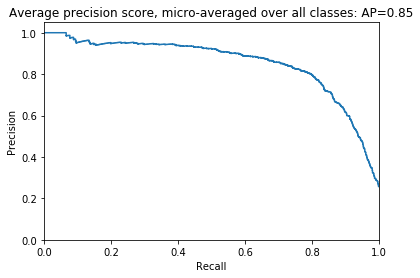

In [70]:
# Plot the micro-averaged Precision-Recall curve
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))
